In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

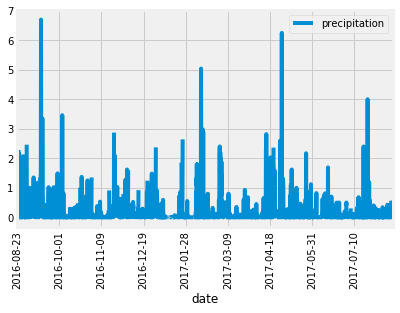

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
# Calculate the date 1 year ago from the last data point in the database

Latest_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Latest Date = 2017-08-23

# Date 1 year ago from Latest Date

Year_Ago = dt.date(2017, 8, 23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

Query_for_last_12_months_precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= Year_Ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

Preciptation_Data_from_last_12_Months_df = pd.DataFrame(Query_for_last_12_months_precipitation_data, columns = ['date', 'precipitation'])
Preciptation_Data_from_last_12_Months_df.set_index(Preciptation_Data_from_last_12_Months_df["date"], inplace=True, )

# Sort the dataframe by date

Preciptation_Data_from_last_12_Months_df = Preciptation_Data_from_last_12_Months_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

Preciptation_Data_from_last_12_Months_df.plot(rot=90)


![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data

Preciptation_Data_from_last_12_Months_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?

number_of_stations = session.query(Station).group_by(Station.station).count()
number_of_stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

Most_Active_Station_Temp_Stats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
Most_Active_Station_Temp_Stats

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

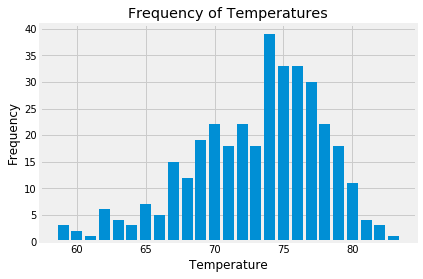

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Query_for_last_12_months_precipitation_data_for_station_with_most_observations = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
group_by(Measurement.tobs).\
filter(Measurement.date > Year_Ago).\
filter(Measurement.station == 'USC00519281').all()

Query_for_last_12_months_precipitation_data_for_station_with_most_observations

# Unpack tuples using list comprehensions

# Unpack the `temperatures` and `frequency` from results and save into separate lists
temperatures = [int(result[0]) for result in Query_for_last_12_months_precipitation_data_for_station_with_most_observations[:len(Query_for_last_12_months_precipitation_data_for_station_with_most_observations)]]
frequency = [int(result[1]) for result in Query_for_last_12_months_precipitation_data_for_station_with_most_observations[:len(Query_for_last_12_months_precipitation_data_for_station_with_most_observations)]]

plt.bar(temperatures, frequency)
plt.title("Frequency of Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Frequency")


![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


C:\Users\dbjohnston\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.


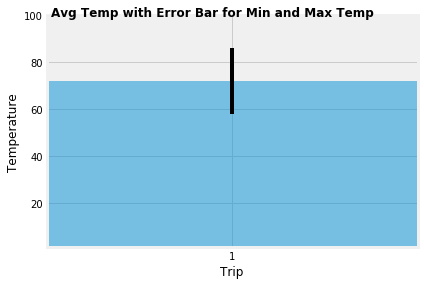

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

results = calc_temps('2017-02-28', '2017-03-05')

results_list = list(np.ravel(results))

peak_to_peak_temp = results_list[2] - results_list[0]
min_temp = results_list[0]
max_temp = results_list[2]
avg_temp = results_list[1]

x = 1
fig, ax = plt.subplots()
fig.suptitle("Avg Temp with Error Bar for Min and Max Temp",
             fontsize=12, fontweight="bold")
ax.bar(1, avg_temp,
       yerr=peak_to_peak_temp,
       align='center',
       alpha=0.5,
       ecolor='black',)
ax.set_xlim(1, 1)
ax.set_ylim(1, 100)
ax.set_xticks([1])
ax.margins = (.2,.2)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
fig.tight_layout()

